We want a metric that is:
- **invariant** to the scale of the data
- **invariant** to the location of the data
- **reproducible** (i.e. always gives the same result for the same data)
- **differentiable** (i.e. we can compute the gradient of the metric with respect to the data)
- **deterministic** (i.e. we can compute the metric without sampling)

In [25]:
import os
import configparser
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import scipy
import time
from toolbox.printing import debug
from skimage.measure import label
from typing import Dict, List, Tuple, Optional, Union

In [2]:
crack_idx = 54
path_image = f"datasets/cracks/cropped/val/images/{crack_idx}.png"
path_mask = f"datasets/cracks/cropped/val/masks/{crack_idx}.png"

In [3]:
# Load image and mask and converts them to numpy arrays
image = Image.open(path_image)
mask = Image.open(path_mask)
image = np.array(image)
mask = np.array(mask)

In [4]:
debug(mask)
debug(np.max(mask))

DEBUG: mask (ndarray: uint8) = [[0, 0, 0, 0, 0, 0, 0, 0, ....], ...] (128, 128)
DEBUG: np.max(mask (uint8) = 1


In [5]:
def show_mask(mask: np.ndarray):
    assert len(mask.shape) == 2, "The mask must be a 2D array"
    assert mask.dtype == bool or (mask.dtype == np.uint8 or mask.dtype == np.int64) and np.max(mask) <= 1, "The mask must be a boolean array"
    plt.imshow(mask, cmap="gray")
    plt.show()

def show_image(image: np.ndarray):
    assert len(image.shape) == 3, "The image must be a 3D array"
    assert image.dtype == np.uint8, "The image must be a uint8 array"
    assert image.shape[2] == 3, "The image must have 3 channels positioned in the last dimension"
    plt.imshow(image)
    plt.show()

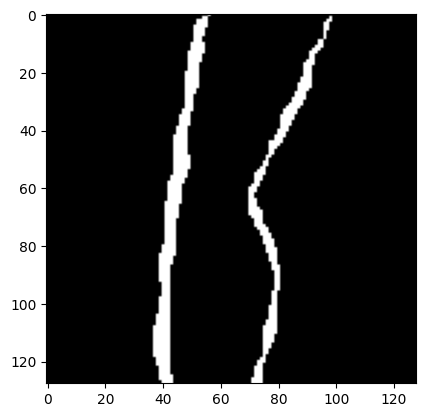

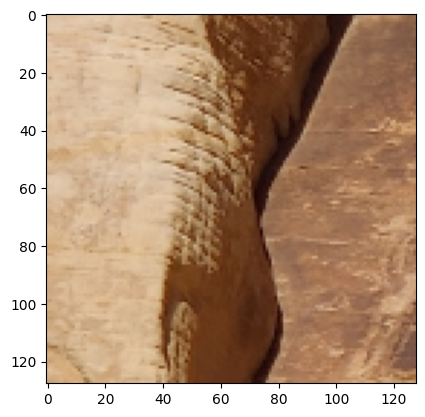

In [6]:
show_mask(mask)
show_image(image)

In [7]:
def separate_mask(mask: np.ndarray):
    assert len(mask.shape) == 2, "The mask must be a 2D array"
    assert mask.dtype == bool or (mask.dtype == np.uint8 or mask.dtype == np.int64) and np.max(mask) <= 1, "The mask must be a boolean array"
    
    separated_mask = label(mask)
    blobs = []
    for i in np.unique(separated_mask):
        if i == 0:  # background
            continue
        blobs.append((separated_mask == i).astype(int))
    return blobs

Found 2 connected components


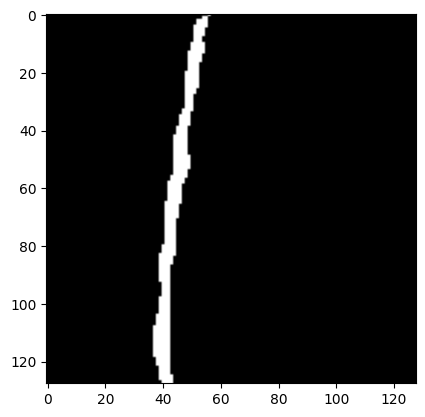

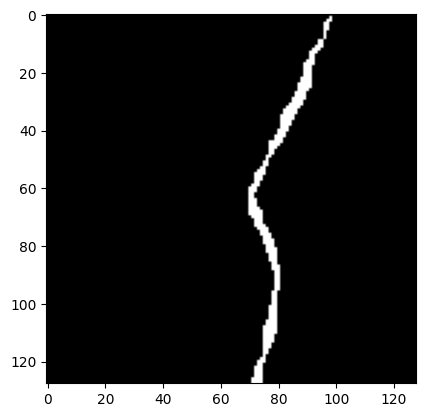

In [8]:
# Label the connected components
masks = separate_mask(mask)
print(f"Found {len(masks)} connected components")
for separated_mask in masks:
    show_mask(separated_mask)


In [9]:
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
import cv2
import numpy as np
from scipy.interpolate import interp1d

In [10]:
# https://stackoverflow.com/questions/56394869/how-to-estimate-piece-wise-smooth-fit-to-a-noisy-mask
skeleton = skeletonize(mask, method='lee')

DEBUG: skeleton (ndarray: uint8) = [[0, 0, 0, 0, 0, 0, 0, ...], ...] (128, 128)


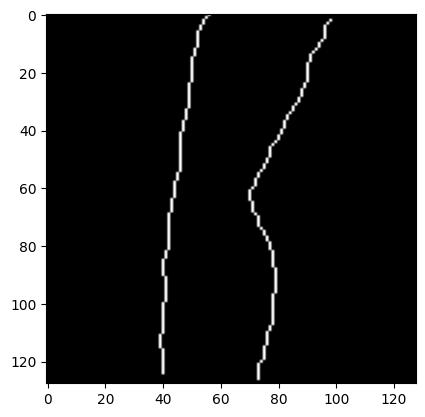

In [11]:
debug(skeleton)
show_mask(skeleton)

In [12]:
def show_masks(masks: List[np.ndarray], colors: Optional[List[List[int]]] = None):
    # Plots a list of masks in different colors
    if colors is None:
        colors = [[255,255,255], [255, 0, 0], [0, 255, 0], [0, 0, 255]]
    assert len(masks) <= len(colors), "Not enough colors to plot the masks"

    # Create a black image
    img = np.zeros((masks[0].shape[0], masks[0].shape[1], 3), np.uint8)
    for i, mask in enumerate(masks):
        img[mask == 1] = colors[i]
    plt.imshow(img)
    plt.show()

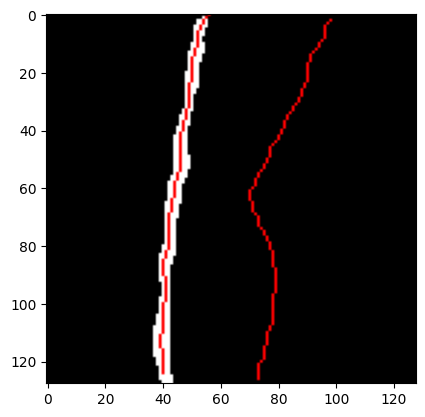

In [13]:
show_masks([masks[0], skeleton])

In [97]:
mask_tensor = torch.from_numpy(masks[0]).unsqueeze(0).unsqueeze(0).float()

NameError: name 'torch' is not defined

In [14]:
# Into dense
contours, _ = cv2.findContours(skeleton, 0,cv2.CHAIN_APPROX_NONE)
arch = contours[0]
x,y = arch[...,0].squeeze(), arch[...,1].squeeze()

# Fitting a curve
xx, yy = x[0::15], y[0::15] #<- sample every 15th element to see that the interpolate really works
f = interp1d(xx, yy)

/home/josselin/.local/lib/python3.8/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/josselin/.local/lib/python3.8/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


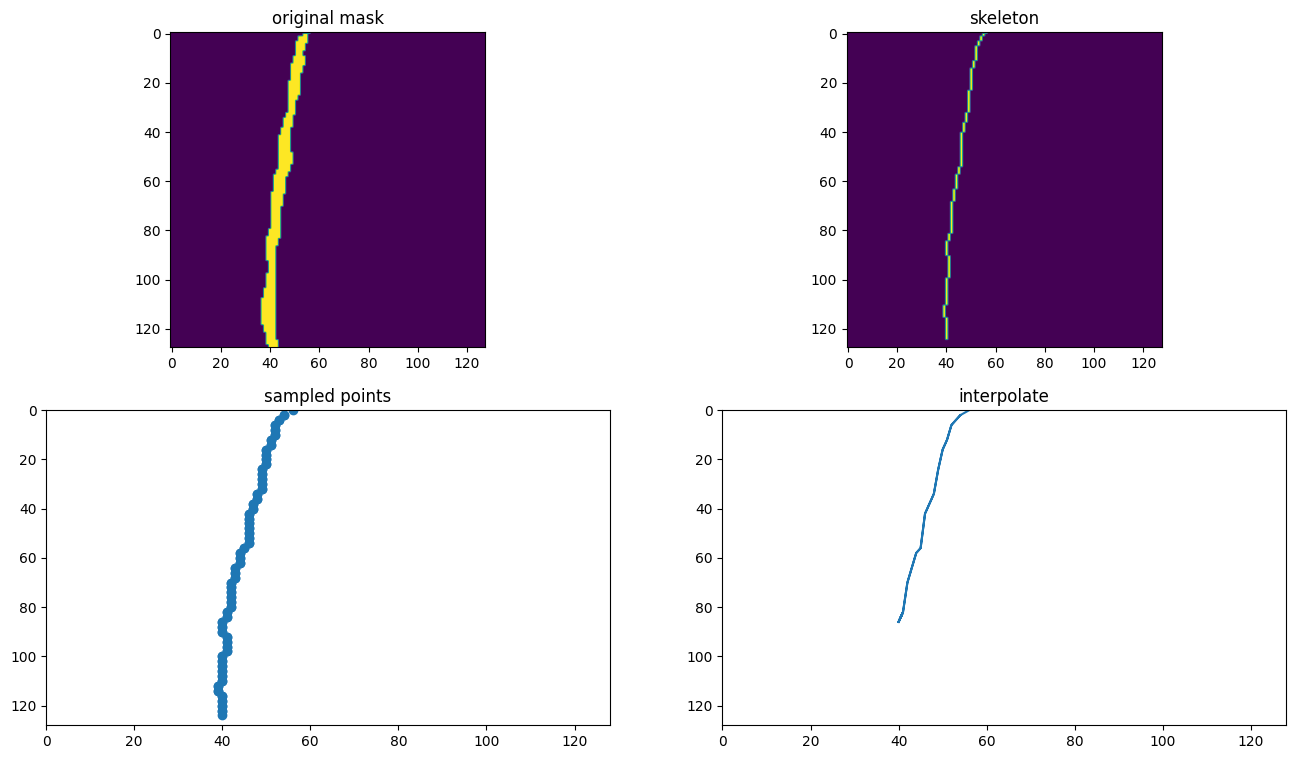

In [19]:
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
import cv2
import numpy as np
from scipy.interpolate import interp1d

#img = cv2.imread("./data/bAiew.png", 0)
#img = cv2.medianBlur(masks[0], 11)
#img = img//255
img = masks[0]

# Sparse skeleton
skeleton = skeletonize(img, method='lee')

# Into dense
contours, _ = cv2.findContours(skeleton, 0,cv2.CHAIN_APPROX_NONE)
arch = contours[0]
x,y = arch[...,0].squeeze(), arch[...,1].squeeze()

# Fitting a curve
xx, yy = x[0::2], y[0::2] #<- sample every 15th element to see that the interpolate really works
f = interp1d(xx, yy)

plt.figure(figsize=(16,9))
plt.subplot(221)
plt.imshow(img)
plt.title('original mask')

plt.subplot(222)
plt.imshow(skeleton)
plt.title('skeleton')

plt.subplot(223)
plt.scatter(xx,yy)
plt.ylim([img.shape[0],0])
plt.xlim([0, img.shape[1]])
plt.title('sampled points')

plt.subplot(224)
plt.plot(xx,f(xx))
plt.ylim([img.shape[0],0])
plt.xlim([0, img.shape[1]])
plt.title('interpolate')
plt.show()

In [26]:
def to_np(image: Union[np.ndarray, Image.Image], dtype: np.dtype = np.float32) -> np.ndarray:
    """
    Converts a PIL image, a numpy array or a PyTorch tensor to a numpy array.
    Converts to an array from 0 to 1 by default.
    The output shape is (height, width, channels).

    Args:
        image: The image to convert.

    Returns:
        The converted image.
    """
    if isinstance(image, Image.Image):
        image = np.array(image)
    elif not isinstance(image, np.ndarray):
        raise ValueError(
            f"Expected image to be a PIL image, a numpy array or a PyTorch "
            f"tensor. Got {type(image)}."
        )

    if image.dtype == np.uint8 and np.max(image) > 1:
        image = image.astype(np.float32) / 255.0

    if image.dtype != dtype:
        # Secial case for binary images. Uses a threshold to prevent rounding errors
        if dtype == bool:
            image = image > 0.5
        else:
            image = image.astype(dtype)

    if image.ndim == 2:
        image = np.expand_dims(image, axis=-1)

    return image

In [46]:
def preprocess_for_comparison(
    ground_truth: Union[np.ndarray, Image.Image],
    prediction: Union[np.ndarray, Image.Image],
    dtype: np.dtype = np.float32,
    diffuse_sigma_factor: float = 0.0) -> Tuple[np.ndarray, np.ndarray]:
    """
    Preprocesses the ground truth and the prediction for comparison.
    Returns both images as numpy arrays of type np.float32 (from 0 to 1).
    Check that the shapes are the same.
    """
    ground_truth = to_np(ground_truth, dtype=dtype)
    prediction = to_np(prediction, dtype=dtype)
    assert ground_truth.shape == prediction.shape, \
        f"Expected ground truth and prediction to have the same shape. " \
        f"Got {ground_truth.shape} and {prediction.shape}."
    
    # Applies a gaussian diffusion to the images
    if diffuse_sigma_factor > 0:
        assert dtype == np.float32, \
            f"Expected dtype to be np.float32 when using a gaussian diffusion. " \
            f"Got {dtype}."
        ground_truth = apply_gaussian_diffusion(ground_truth, diffuse_sigma_factor)
        prediction = apply_gaussian_diffusion(prediction, diffuse_sigma_factor)

    return ground_truth, prediction

In [130]:
def get_bounding_box(mask) -> Tuple[int, int, int, int]:
    """
    Returns the bounding box of a binary mask.
    The bounding box is defined as (x_min, y_min, x_max, y_max).
    """
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    x_min, x_max = np.where(cols)[0][[0, -1]]
    y_min, y_max = np.where(rows)[0][[0, -1]]
    return x_min, y_min, x_max, y_max

def crop_to_bounding_box(
    image: Union[np.ndarray, Image.Image],
    bounding_box: Tuple[int, int, int, int]) -> Union[np.ndarray, Image.Image]:
    """
    Crops an image to a bounding box.
    The bounding box is defined as (x_min, y_min, x_max, y_max).
    """
    if isinstance(image, Image.Image):
        return image.crop(bounding_box)
    else:
        return image[bounding_box[1]:bounding_box[3], bounding_box[0]:bounding_box[2]]

def get_shared_bounding_box(mask1, mask2) -> Tuple[int, int, int, int]:
    """
    Returns the smallest bounding box such that boths masks are contained in it."""
    x_min1, y_min1, x_max1, y_max1 = get_bounding_box(mask1)
    x_min2, y_min2, x_max2, y_max2 = get_bounding_box(mask2)
    x_min = min(x_min1, x_min2)
    y_min = min(y_min1, y_min2)
    x_max = max(x_max1, x_max2)
    y_max = max(y_max1, y_max2)
    return x_min, y_min, x_max, y_max

def crop_as_small_as_possible(mask1, mask2):
    """Crop both masks to their shared bounding box."""
    x_min, y_min, x_max, y_max = get_shared_bounding_box(mask1, mask2)
    mask1 = crop_to_bounding_box(mask1, (x_min, y_min, x_max, y_max))
    mask2 = crop_to_bounding_box(mask2, (x_min, y_min, x_max, y_max))
    return mask1, mask2

In [261]:
def crack_metrics(
    ground_truth: Union[np.ndarray, Image.Image],
    prediction: Union[np.ndarray, Image.Image],
    sigma_factor: float = 0.1,
    crop: bool = True) -> Dict[str, float]:
    ground_truth, prediction = preprocess_for_comparison(ground_truth, prediction, dtype=bool)
    sigma = sigma_factor * np.sqrt(ground_truth.shape[0] * ground_truth.shape[1])
    if crop: ground_truth, prediction = crop_as_small_as_possible(ground_truth, prediction)
    num_pixels_gt = np.sum(ground_truth)
    num_pixels_pred = np.sum(prediction)

    # Skeletonizes the ground truth and the prediction
    # First crop the images as small as possible to speed up the computation
    skeleton_gt = skeletonize(ground_truth, method='lee')
    skeleton_pred = skeletonize(prediction, method='lee')
    lenght_gt = np.sum(skeleton_gt)
    length_pred = np.sum(skeleton_pred)

    # Computes the ratio of length
    length_ratio = np.exp(- 1.0 * np.abs(lenght_gt.astype(float) - length_pred) / lenght_gt) 

    # Computes the distance between the two skeletons
    if lenght_gt == 0 and length_pred == 0:
        line_distance_score = 1.
    elif lenght_gt == 0 or length_pred == 0:
        line_distance_score = 0.
    else:
        distances_gt = scipy.ndimage.distance_transform_edt(skeleton_gt == 0)
        distances_pred = scipy.ndimage.distance_transform_edt(skeleton_pred == 0)
        distance_factor_gt = np.sum(skeleton_pred * np.exp(-distances_gt ** 2 / (2 * sigma ** 2))) / lenght_gt
        distance_factor_pred = np.sum(skeleton_gt * np.exp(-distances_pred ** 2 / (2 * sigma ** 2))) / length_pred
        line_distance_score = distance_factor_gt * distance_factor_pred

    # Computes the width score
    # A simple approximation is simply the ratio of the number of pixels
    # To decorelate this from the length score
    width_ratio = num_pixels_gt * length_pred / (num_pixels_pred * lenght_gt)
    width_ratio = np.exp( - np.abs(1 - width_ratio))

    # Intersection and union
    intersection = np.sun(np.logical_and(ground_truth, prediction))
    union = np.sum(np.logical_or(ground_truth, prediction))
    iou = intersection / union
    dice = 2 * intersection / (intersection + union)


    results = {
        'length': length_ratio,
        'line_distance': line_distance_score,
        'width': width_ratio,
        'iou': iou,
        'dice': dice
    }
    return results

if we double the scale, then:
- $d = \sqrt{x^2 + y^2}$ becomes $d' = \sqrt{(2x)^2 + (2y)^2} = 2d$
- $\sigma$ also doubles so we are good

In [262]:
def generate_prediction(mask, movement=1, scale=1, noise=1):
    prediction = mask.copy()
    # Introduce random translation, rotation and even scaling (small amount)
    prediction = scipy.ndimage.rotate(prediction, np.random.uniform(-10*movement, 10*movement), reshape=False)
    prediction = scipy.ndimage.shift(prediction, np.random.uniform(-10*movement, 10*movement, size=2))
    # Zoom but keep the same size
    prediction = scipy.ndimage.zoom(prediction, np.random.uniform(1-0.1*scale, 1+0.1*scale))
    # If the image is too big, crop it
    if prediction.shape[0] > mask.shape[0] or prediction.shape[1] > mask.shape[1]:
        prediction = prediction[:mask.shape[0], :mask.shape[1]]
    # If the image is too small, pad it
    if prediction.shape[0] < mask.shape[0] or prediction.shape[1] < mask.shape[1]:
        prediction = np.pad(prediction, ((0, mask.shape[0]-prediction.shape[0]), (0, mask.shape[1]-prediction.shape[1])), mode='constant')
    # Add noise
    prediction = prediction + np.abs(np.random.normal(0, 0.7 * noise, prediction.shape)) / (1+scipy.ndimage.distance_transform_edt(prediction <= 0.5))**2
    prediction = prediction >= 0.5
    return prediction

In [263]:
prediction = generate_prediction(masks[1], movement=3.0, scale=0, noise = 0)

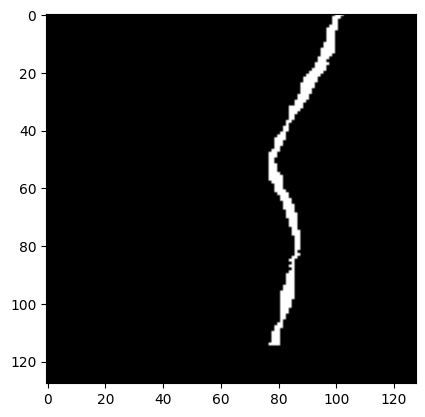

In [264]:
show_mask(prediction)

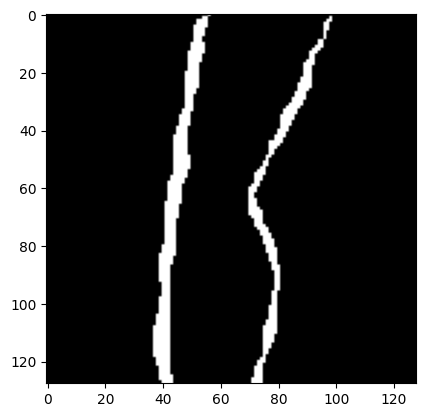

In [265]:
show_mask(mask)

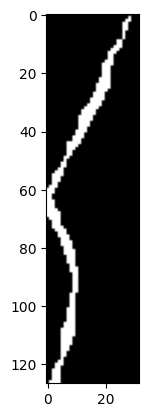

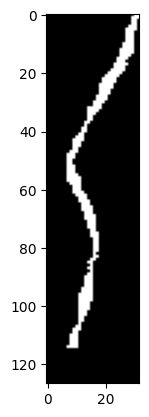

In [266]:
mask_cropped, pred_cropped = crop_as_small_as_possible(masks[1], prediction)
show_mask(mask_cropped)
show_mask(pred_cropped)

In [267]:
crack_metrics(masks[1], prediction)

{'length': 0.9151112124608817,
 'line_distance': 0.8390528554524693,
 'width': 0.9663488663699512,
 'total': 0.9068376447611007}

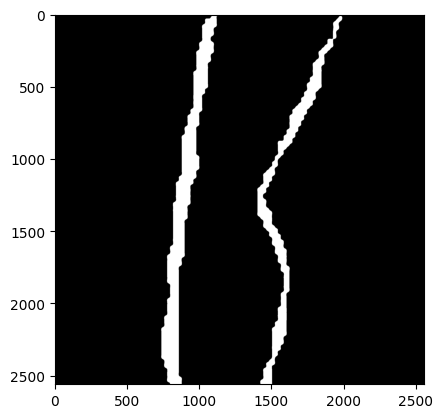

0.4934663572744836

In [194]:
# Scaleb by two the mask and checks that we get the same result
mask_2x = scipy.ndimage.zoom(mask, 20)
show_mask(mask_2x)
predicion_2x = scipy.ndimage.zoom(prediction, 20)
binary_distance_proximity(skeletonize(mask_2x, method='lee'), skeletonize(predicion_2x, method='lee'))